# Randomized Benchmarking: Unitarity RB


## Background


在本笔记本中，我们探索 randomized_benchmarking.py 中与单一性随机基准测试特别相关的方法子集。 我建议首先查看笔记本示例/randomized_benchmarking.ipynb，因为我们将假设熟悉其内容并将单一性视为对“标准”RB 协议的修改。

在标准 RB 中，我们感兴趣的是表征噪声对门的平均影响，并且我们估计每个 Clifford 的平均错误率。 Unityarity RB 旨在进一步表征这种噪声。 有两种不同类型的噪声会影响目标操作的质量:
- coherent 或 unitary 的噪声，可能是由于 imperfect control 或 improper calibration 而产生的，从而导致 the resulting operation 是 unitary ，但与 the target gate 不同。 例如，coherent error 的极端情况是在尝试执行目标 Z 门时实现完美的 X 门。 coherent noise 的一种更常见和潜在的情况是 over or under rotation(过度旋转或旋转不足) ，例如 对目标 RX(pi) 门执行 RX(pi + .001)。
- incoherent noise 使整体操作变得 non-unitary，并且可以通过与环境的 unwanted interaction 将受 the affected state 从 the computational subspace rotate 到更大的 system + environment space。 对于 the Bloch sphere 上表示的单个量子位状态，这具有将状态向量移动到更靠近球体中心的效果。The depolarizing channel 是 incoherent error 的原型，在单量子位情况下，它会将布洛赫球体的表面均匀收缩到中心点。 Amplitude damping 是另一个例子，对于单个量子位，布洛赫球体的表面收缩到 $|0\rangle$ 状态极点。

The unitarity measurement 旨在提供噪声相干程度的估计 (how coherent the noise is)。 在描述示例时我们已经看到两种不同类型的噪声以不同的方式影响状态。 着眼于单量子位态的布洛赫球体表示，fully coherent (unitary) noise 会像任何其他酉操作一样旋转球体的表面； 与此同时，incoherent noise 会缩小 volume of the sphere(球体的体积)，并且通常会平移其中心。 我们将利用这两个动作在不同状态下的差异来表征噪声。
正如在 RB 中一样，我们将估计深度增加的 Clifford 门随机序列组上某个quantity（the shifted purity）的平均值，拟合指数衰减曲线，并提取基本衰减常数的估计。 在这种情况下，衰减常数被称为 “unitarity”，并采用 0 到 1 之间的值（含 0 和 1）。 Purely coherent noise（如外来酉门的情况）产生的幺正性为 1，而purely incoherent noise（如去偏振通道）产生的幺正性为 0。


### Purity


参考:
1. https://en.wikipedia.org/wiki/Purity_%28quantum_mechanics%29
The purity $p$ of quantum state $\rho$ is defined as the trace of the density matrix squared:
$$p(\rho) = tr(\rho^2)$$
纯单量子位状态的集合，即$p=1$，正是构成布洛赫球面的状态集。事实上，我们可以将状态的Purity与广义布洛赫球中状态向量的长度联系起来。使用完整的算子基础，例如 pauli 基础，我们可以扩展任何d维度的量子态变为下述线性组合形式：
$$ \rho = (I + \sum_k n_k \sigma_k) / d = (I + \sum_k tr[\rho \sigma_k] \sigma_k)/d $$
我们将 the traceless pauli matrices 表示为$\{\sigma_k\}$，在这里我们看到纯度为：
$$p = tr(\rho^2) = 1/d + ||\vec n||^2/d$$
其中$\vec n = (n_1, n_2, \dots, n_{d-1})$为Bloch vector。量子态的纯度位于区间$[1/d, 1]$。在 [ECN] 之后，我们定义了介于 0 和 1 之间的偏移（或归一化）纯度：
$$p' = \frac{d (p - 1 / d)}{d-1} = ||\vec n||^2/(d-1)$$

结合上述所有观察结果，我们估计在非相干噪声的作用下，一个初始态为纯态的 the shifted purity $p'$。例如，随着布洛赫矢量收缩到原点，重复应用去极化通道会在许多应用过程中从 1 衰减到 0。事实上，the shifted purity 取代了标准 RB 的 the survival probability。为了估计纯度，我们采用每个在给定的序列上测量无痕 pauli 算符 $\sigma_k$的期望。



### The protocol


幺正性和 RB 之间有两个区别。 首先也是最重要的，我们估计每个序列的 purity 而不是survival probability。 其次，我们不需要 Cliffords 序列是 self-inverting。 因此，该过程总结为
- 选择一些 the survival probability 会显着衰减的深度
- 为每个深度生成许多随机序列。随机序列只是深度众多的均匀随机 Clifford 元素。
- 通过估计运行序列后，每个 traceless Pauli observable 的期望，从而实现估计每个序列的 "shifted purity"，；这里大量使用了 ObservablesExperiment 框架。
- 将指数衰减模型拟合到估计的 shifted purities。
- 从拟合中提取the decay parameter（unitarity）。由此我们可以得到标准 RB 衰减的上限。如果噪声通道是去极化通道，则该上限饱和。

For more information, including a formal definition of unitarity, see

| [ECN] Estimating the Coherence of Noise.
| Wallman et al.
| New Journal of Physics 17, 113020 (2015).
| https://dx.doi.org/10.1088/1367-2630/17/11/113020
| https://arxiv.org/abs/1503.07865

We also make use of unitarity in the notebook examples/randomized_benchmarking_interleaved.ipynb

## URB code

In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np
from forest.benchmarking.plotting import plot_figure_for_fit
from forest.benchmarking.randomized_benchmarking import *

from pyquil.api import BenchmarkConnection
from pyquil import Program, get_qc

noisy_qc = get_qc('2q-qvm', noisy=True)
bm = BenchmarkConnection()

由于我们为每个序列估计的observables 比标准 RB 更多，因此这将需要更长的时间。

默认情况下，每个序列上的所有observables都会分组，以便从同一组测量同时估计兼容的可观测量。 这加快了数据采集速度。 估计的observables的数量是最大量子位组大小的平方。

100%|██████████| 200/200 [09:34<00:00,  2.87s/it]
d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2074: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2195: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


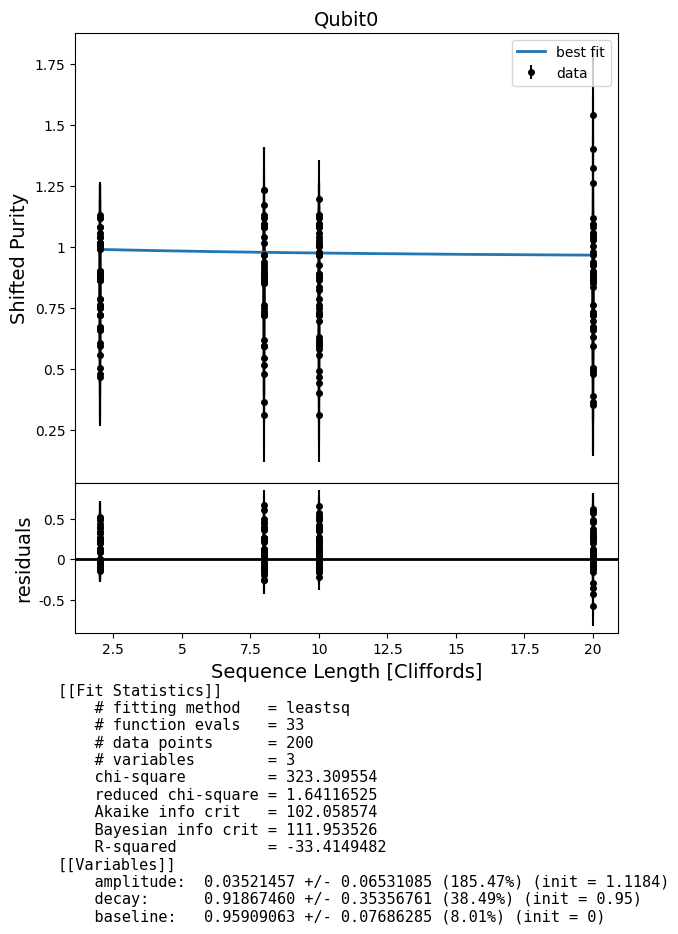

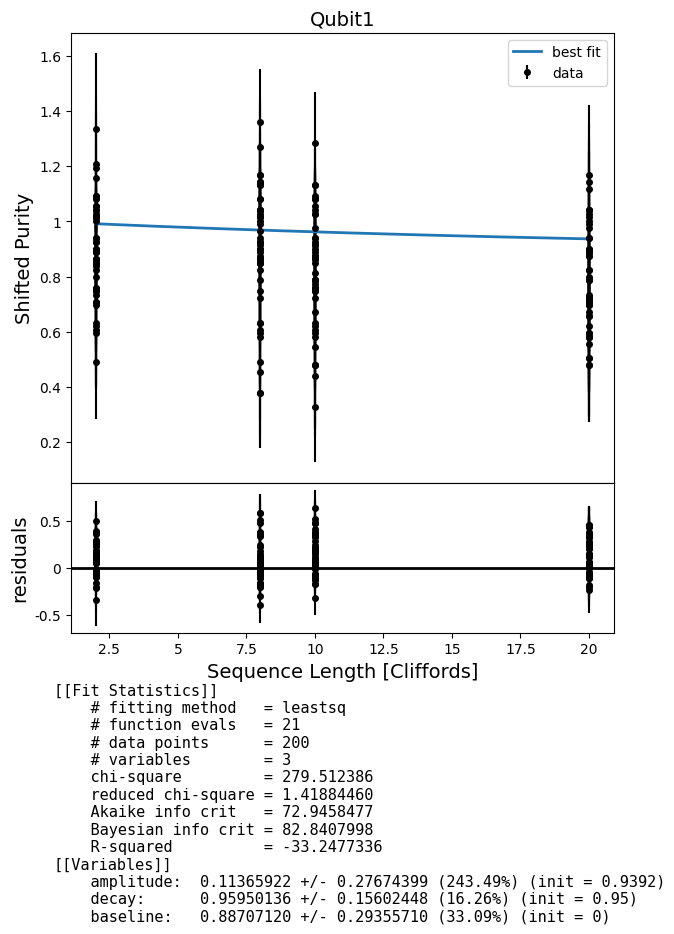

In [2]:
# THIS IS SLOW (around a minute). The below comment skips this cell during testing. Please do not remove.
# NBVAL_SKIP
num_sequences_per_depth = 50
num_shots = 25

# select groups of qubits. Here we choose to simultaneously run two 
# single qubit experiments on qubit 0 and qubit 1
qubit_groups = [(0,), (1,)]
depths = [2, 8, 10, 20]
depths = [d for d in depths for _ in range(num_sequences_per_depth)]

expts = generate_unitarity_experiments(bm, qubit_groups, depths)

results = acquire_rb_data(noisy_qc, expts, num_shots, show_progress_bar=True)
stats_by_group = get_stats_by_qubit_group(qubit_groups, results)
fits = []
for group in qubit_groups:
    stats = stats_by_group[group]
    fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])
    fits.append(fit)
    fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity", 
                       title='Qubit' + str(group[0]))

默认的 qvm 噪声模型不会产生漂亮的曲线。我们将在下面解决这个问题。


### Advanced functionality: inserting simple-to-analyze noise


In [3]:
from pyquil import noise

def add_noise_to_sequences(sequences, qubits):
    """
    Append the given noise to each clifford gate (sequence)
    """
    for seq in sequences:
        for program in seq:
            program.inst(("noise", *qubits))
            
def add_noise_definition(expt, qubits, kraus_ops):
    p = Program()
    p.defgate("noise", np.eye(2 ** len(qubits)))
    p.define_noisy_gate("noise", qubits, kraus_ops)
    expt.program = p + expt.program
    
def depolarizing_noise(num_qubits: int, p: float =.95):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by a depolarizing noise channel.

    :params float num_qubits: either 1 or 2 qubit channel supported
    :params float p: parameter in depolarizing channel as defined by: p $\rho$ + (1-p)/d I
    :return: A list, eg. [k0, k1, k2, k3], of the Kraus operators that parametrize the map.
    :rtype: list
    """
    num_of_operators = 4**num_qubits
    probabilities = [p+(1.0-p)/num_of_operators] + [(1.0 - p)/num_of_operators]*(num_of_operators-1)
    return noise.pauli_kraus_map(probabilities)

# get a qc without any noise
quiet_qc = get_qc('1q-qvm', noisy=False)

应用于每个 Clifford 的A depolarizing channel特别容易分析。 特别是，我们期望能够将估计的幺正性转换为参数化通道的 RB 衰减参数。

为了插入噪声，我们必须使用组成generate_unitarity_experiments的各个部分，类似于我们在标准RB的高级部分中所做的。


100%|██████████| 200/200 [09:07<00:00,  2.74s/it]
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


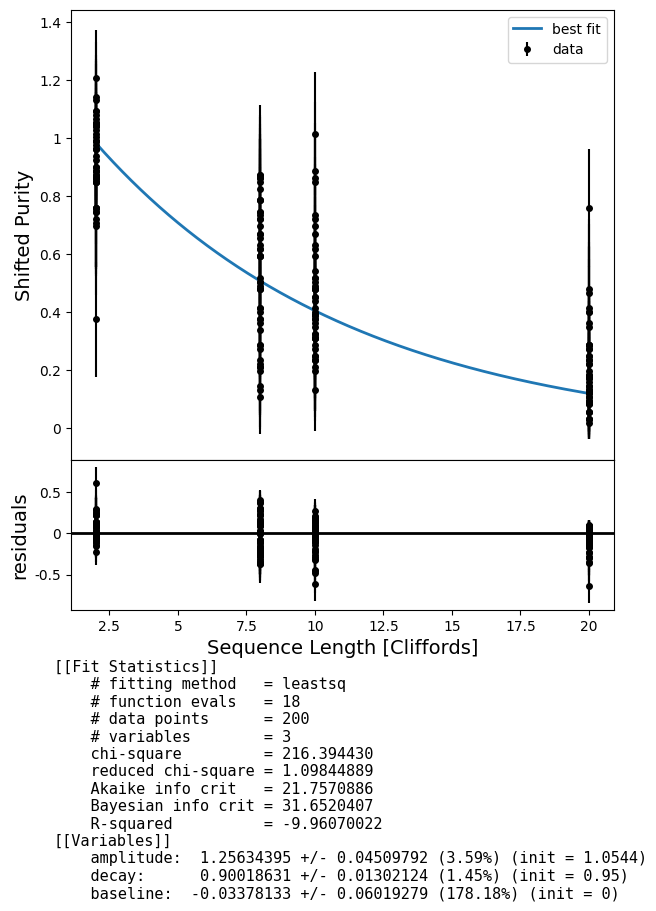

In [4]:
# This is also SLOW
qubits = (0,)

single_clifford_p = .95 # p parameter for the depolarizing channel applied to each clifford
kraus_ops = depolarizing_noise(len(qubits), single_clifford_p)


depths = [2, 8, 10, 20]
depths = [d for d in depths for _ in range(num_sequences_per_depth)]


sequences = generate_rb_experiment_sequences(bm, qubits, depths, use_self_inv_seqs=False)

# insert our custom noise
add_noise_to_sequences(sequences, qubits)

expts = group_sequences_into_parallel_experiments([sequences], [qubits], is_unitarity_expt=True)

for expt in expts:
    add_noise_definition(expt, qubits, kraus_ops)

results = acquire_rb_data(quiet_qc, expts, num_shots, show_progress_bar=True)

stats = get_stats_by_qubit_group([qubits], results)[qubits]
fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])

# plot the raw data, point estimate error bars, and fit
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")

In [5]:
unitarity = fit.params['decay'].value
print(unitarity)
err = fit.params['decay'].stderr
print(err)

0.9001863107635831
0.01302123939687058


由于噪声是去极化的，我们期望 unitarity_to_rb_decay(unitarity) 与输入噪声参数 single_clifford_p = 0.95 匹配，直至达到我们估计的误差。


In [6]:
from forest.benchmarking.randomized_benchmarking import unitarity_to_rb_decay
# unitarity_to_rb_decay，假设不存在幺正性误差，将幺正性衰减转换为标准 RB 衰减。

print(f'{unitarity_to_rb_decay(unitarity-err, 2)} '\
      f'<? {single_clifford_p} '\
      f'<? {unitarity_to_rb_decay(unitarity+err, 2)}')

0.9418944056351075 <? 0.95 <? 0.9556189356435199
